In [2]:
%load_ext autoreload
%autoreload 2
import sys
import torch 
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
sys.path.insert(0, '../MIMIC_notebooks')
sys.path.insert(0, '../')


from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split

from sarpu.pu_learning import *
from sarpu.PUmodels import LogisticRegressionPU
from km.Kernel_MPE_grad_threshold import wrapper as ramaswamy

from gpu_utils import restrict_GPU_pytorch
from method import load_model, get_model_fname
from baseline_params import penalty, solver, fit_intercept

from mimic_helper_fs import MODE_GROUP_MAP, preprocess_mimic_data, normalize_x, get_group_weights
from paths import FIG_DIR, RESULTS_DIR
from sklearn.calibration import calibration_curve
from mimic_helper_fs import prettify_group_name, prettify_category_name
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

restrict_GPU_pytorch('0')
# Marital status lamda is 0 
# Insurance is  1e-6, depends on the seed
# Ethnicity is.. undetermined?

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using GPU:0


### Visual comparison of Unconstrained model and PURPLE

In [4]:
dfs = []

method = 'ours'
val_loss_key = 'auprc'
categories = ['marital_status', 'ethnicity', 'insurance']
modes = MODE_GROUP_MAP.keys()

for i, category in enumerate(categories):
    df = pd.read_csv(RESULTS_DIR + "real_ipv_" + method + "_" + category + "_results_teststratified_by_none")
    df = df.groupby('seed').first().reset_index()
    df['estimator_type'] = 'PURPLE'
    dfs.append(df)
purple_df = pd.concat(dfs)
purple_df = purple_df.sort_values([val_loss_key], ascending=False).groupby(['category', 'group', 'seed']).head(1)
purple_df = purple_df.reset_index()

sklearn_uc_df = pd.read_csv(RESULTS_DIR + 'unconstrained_ipv_results_sklearn' )
sklearn_uc_df = sklearn_uc_df.sort_values([val_loss_key], ascending=False).groupby(['category', 'seed']).head(1)
sklearn_uc_df = sklearn_uc_df.reset_index()
sklearn_uc_df['estimator_type'] = 'Unconstrained'
pytorch_uc_df = pd.read_csv(RESULTS_DIR + 'unconstrained_ipv_results' )
pytorch_uc_df['estimator_type'] = 'pytorch_unconstrained' 
# uc_df['estimator_type'] = 'unconstrained'
all_results_df = pd.concat([sklearn_uc_df, purple_df])

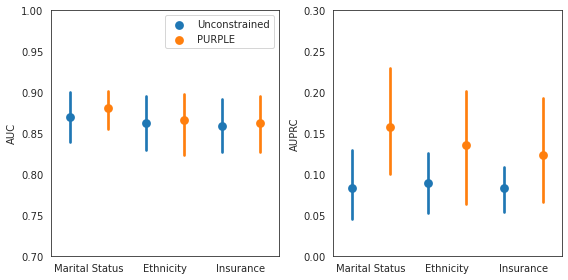

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for i, val_loss_key in enumerate(['auc', 'auprc']):
    ax = axs[i]
    all_results_df['pretty_category'] = all_results_df['category'].apply(lambda x : prettify_category_name[x])
    sns.pointplot(x='pretty_category', hue='estimator_type', y=val_loss_key, dodge=.5, join=False, 
                  data=all_results_df, ax=ax)
    if i != 0:
        ax.legend().remove()
        ax.set_ylim(0, .3)
        ax.set_ylabel("AUPRC")
    else:
        ax.set_ylim(.7, 1)
        ax.set_ylabel("AUC")
        ax.legend_.set_title(None)

#         ax.legend().texts[0].set_text("")
#         handles, labels = ax.get_legend_handles_labels()
#         ax.legend(handles=handles[1:], labels=labels[1:])
    ax.set_xlabel("")
    
plt.tight_layout()
plt.savefig(FIG_DIR + "/ipv_auprc_auc_checks.pdf", dpi=300)

### Print out table of AUCs and AUPRCs

In [236]:
# Unconstrained
pd.set_option('precision', 3)

df = sklearn_uc_df
df['estimator_type'] = 'Unconstrained'
mean_df = df.groupby('category').mean().reset_index()
std_df = df.groupby('category').std().reset_index()

mean_df.rename(columns={'auc': 'auc_mean', 'auprc': 'auprc_mean'}, inplace=True)
std_df.rename(columns={'auc': 'auc_std', 'auprc': 'auprc_std'}, inplace=True)

def combine_columns(auc_mean, auc_std):
    return "$" + '{0:.3f}'.format(auc_mean) + ' ± ' + '{0:.3f}'.format(auc_std) + "$"

def combine_mean_std_df(mean_df, std_df):
    df = pd.merge(mean_df, std_df, left_on='category', right_on='category')
    df['auc'] = df.apply(lambda row: combine_columns(row['auc_mean'], row['auc_std']), axis=1)
    df['auprc'] = df.apply(lambda row: combine_columns(row['auprc_mean'], row['auprc_std']), axis=1)
    return df
uc_df = combine_mean_std_df(mean_df, std_df)
uc_df.index = uc_df.category
uc_df.rename(columns={'auc': 'Unconstrained (AUC)', 
                   'auprc': 'Unconstrained (AUPRC)'}, inplace=True)
uc_df = uc_df[['Unconstrained (AUC)', 'Unconstrained (AUPRC)']].T.reset_index()

In [237]:
mean_df = purple_df.groupby('category').mean().reset_index()[['category', 'auc', 'auprc']]
std_df = purple_df.groupby('category').std().reset_index()[['category', 'auc', 'auprc']]

mean_df.rename(columns={'auc': 'auc_mean', 'auprc': 'auprc_mean'}, inplace=True)
std_df.rename(columns={'auc': 'auc_std', 'auprc': 'auprc_std'}, inplace=True)

purple_means_df = combine_mean_std_df(mean_df, std_df)
purple_means_df.index = purple_means_df.category
purple_means_df.rename(columns={'auc': '\texttt{PURPLE} (AUC)', 
                   'auprc': '\texttt{PURPLE} (AUPRC)'}, inplace=True)
purple_means_df = purple_means_df[['\texttt{PURPLE} (AUC)', '\texttt{PURPLE} (AUPRC)']].T.reset_index()

In [238]:
df = pd.concat([purple_means_df, uc_df], ignore_index=True, axis=0)
df.rename(columns={"ethnicity":"Ethnicity", 
                   "insurance":"Insurance",
                   "marital_status":"Marital Status"
                  }, inplace=True)
latex_str = df.to_latex(escape=False, column_format="r|llll", index=False)
latex_str = latex_str.replace("±", "\pm")
print(latex_str)

\begin{tabular}{r|llll}
\toprule
                   index &        Ethnicity &        Insurance &   Marital Status \\
\midrule
   \texttt{PURPLE} (AUC) &  $0.866 \pm 0.047$ &  $0.862 \pm 0.045$ &  $0.880 \pm 0.030$ \\
 \texttt{PURPLE} (AUPRC) &  $0.135 \pm 0.092$ &  $0.123 \pm 0.082$ &  $0.158 \pm 0.089$ \\
     Unconstrained (AUC) &  $0.863 \pm 0.043$ &  $0.859 \pm 0.041$ &  $0.870 \pm 0.040$ \\
   Unconstrained (AUPRC) &  $0.088 \pm 0.049$ &  $0.083 \pm 0.034$ &  $0.083 \pm 0.056$ \\
\bottomrule
\end{tabular}



### T-Test for Significant Differences in AUPRC / AUC

In [245]:
from scipy.stats import ttest_ind
ttest_df = pd.merge(sklearn_uc_df, purple_df, left_on=['category', 'seed'], right_on=['category', 'seed'])
for category in set(ttest_df['category']):
    category_ttest_df = ttest_df[ttest_df['category'] == category]
    print(category)
    print(ttest_ind(category_ttest_df['auprc_x'], category_ttest_df['auprc_y']))
    print(ttest_ind(category_ttest_df['auc_x'], category_ttest_df['auc_y']))
# Neither AUcs or AUPRcs are  significantly different in any category

insurance
Ttest_indResult(statistic=-1.0053699623892367, pvalue=0.3441555795619743)
Ttest_indResult(statistic=-0.12749398308169352, pvalue=0.9016959188018236)
ethnicity
Ttest_indResult(statistic=-0.9940112861814515, pvalue=0.3493278270589196)
Ttest_indResult(statistic=-0.1219305960119746, pvalue=0.9059611829067633)
marital_status
Ttest_indResult(statistic=-1.5943754768994145, pvalue=0.14951800986342914)
Ttest_indResult(statistic=-0.46752728502525176, pvalue=0.6525936077618792)


### Comparison of group-specific calibration

In [27]:
n_runs = 5
stratify_mode = 'none'

scar_assumption = True
seeds = [10, 52, 30, 42, 1000]
classification_model_type = LogisticRegressionPU

lamda_opts = [0]
split_dir = "../../data/real_true_labels/hospital/ipv/0/"
x = load_npz(split_dir + 'vals.npz').todense()
s = np.loadtxt(split_dir + "observed_labels")
hadm_ids = np.loadtxt(split_dir + 'row_names')
subject_ids = np.loadtxt(split_dir + 'subject_ids')


condition = 'ipv'
method = 'ours'
modes = MODE_GROUP_MAP.keys()
results = []
for i, mode in tqdm(enumerate(modes)):
    groups = MODE_GROUP_MAP[mode]

    results_f_name = RESULTS_DIR + "real_" + condition + "_" + method + "_" + mode + "_results_test"
    results_f_name += "stratified_by_none"

    # meta experiment config
    n_groups = len(groups)
    n_attributes = x.shape[1]
    classification_attributes = np.array(list(range(n_attributes))) + n_groups
    norm_flag = 'unnorm'

    ### Enumerate experiment configurations
    expmt_configs = []
    for j in range(n_runs):
        for lamda in lamda_opts:
            expmt_config = {'scar_assumption': True, 
                            'lamda': lamda, 'n_groups': n_groups,
                            'n_attributes': n_attributes, 'groups': groups, 
                            'labeling_frequencies': (None, None),
                            'category': mode, 'n_epochs': 10000, 
                            'optimizer': 'Adam',
                            'seed': seeds[j], 
                            'estimator_type': 'logreg', 
                            'mode': norm_flag, 'n_batches': 20,
                            'stratify_mode': stratify_mode} 
            expmt_configs.append(expmt_config)
    
    ### Plot calibration plot based on first config
    for expmt_config in expmt_configs:
        groups = expmt_config['groups']
        seed = expmt_config['seed']

        ### Preprocess mimic data 
        train, val, test = preprocess_mimic_data(x, [], s, hadm_ids, subject_ids,
                                                 groups, expmt_config, seed)

        x_train, y_train, s_train = train
        x_val, y_val, s_val = val
        x_test, y_test, s_test = test

        train_data, val_data, test_data = x_train, x_val, x_test
        expmt_config['group_weights'] = get_group_weights(x_train, expmt_config['n_groups'])

        model_fname = get_model_fname(expmt_config)
        model_fname = model_fname + 'model_final_10000'
        f_model = load_model(model_fname, expmt_config)

        f_model.cuda()
        s_test_preds = f_model(torch.Tensor(test_data).cuda()).detach().cpu().numpy().flatten()

        for j, group in enumerate(groups):
            group_idxs = np.squeeze(np.where(test_data[:,j] == 1)[0])
            n_bins = 4
            cal_y_1, cal_x_1 = calibration_curve(s_test[group_idxs], s_test_preds[group_idxs], n_bins=n_bins, strategy='quantile')
            results.extend([{'x': x_val, 'y': y_val, 
                             'seed': seed, 'mode': mode,
                             'group': group, 'quintile': i, 
                             'n_group_examples': len(group_idxs)} for i,(x_val, y_val) in enumerate(zip(cal_x_1, cal_y_1))])

3it [05:52, 117.43s/it]


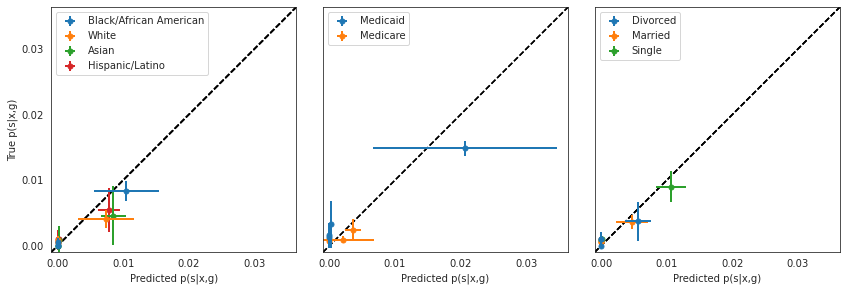

In [29]:

results_df = pd.DataFrame(results)
results_df.to_csv(RESULTS_DIR + "ipv_calibration_over_splits")
results_df = pd.read_csv(RESULTS_DIR + "ipv_calibration_over_splits")
results_df = results_df[results_df['n_group_examples'] >= 500]
# results_df['group']  = results_df['group'].apply(lambda x: prettify_group_name[x])
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for i, mode in enumerate(modes):
    groups = MODE_GROUP_MAP[mode]
    ax = axs[i]
    plt.sca(ax)
    mode_results_df = results_df[results_df['mode'] == mode]

    for j, group in enumerate(groups):
        group_results_df = mode_results_df[mode_results_df['group'] == group]
#         print(mode, group)
        if len(group_results_df):
            x_y_means = group_results_df.groupby(['quintile']).mean().reset_index()[['x', 'y']]
            x_y_std_errs = group_results_df.groupby(['quintile']).std().reset_index()[['x', 'y']]
#             print(x_y_std_errs)
            plt.errorbar(x_y_means['x'], x_y_means['y'], xerr=x_y_std_errs['x'], yerr=x_y_std_errs['y'], capsize=0, ls='none', 
                        elinewidth=2, label=prettify_group_name[group], fmt='o',  ms=5, lw=1, zorder=-j)
#             ax.set_xscale('log')
#             ax.set_yscale('log')
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            min_val, max_val = min(xmin, ymin), max(ymax, xmax)
            min_val, max_val = -0.0003920702637947136, 0.036366542984755564
            min_val, max_val = -0.0009920702637947136, 0.036366542984755564

            ax.set_ylim(min_val, max_val)
            ax.set_xlim(min_val, max_val)
            ax.locator_params(nbins=4, axis='x')
            ax.locator_params(nbins=4, axis='y')

            ax.plot([min_val, max_val], [min_val, max_val], c='black', ls='--', zorder=-20)
            ax.set_xlabel("Predicted p(s|x,g)")
            if  i == 0:
                ax.set_ylabel("True p(s|x,g)")
            ax.legend(loc='upper left')
            ax.set_aspect('equal')
#             ax.xaxis.set_ticks_position('bottom')
#             ax.yaxis.set_ticks_position('left')



    print()
plt.tight_layout()
plt.savefig(FIG_DIR + "ipv_calibration_plots.pdf", dpi=300, format='pdf', bbox_inches='tight')